### sindy prediction of the collected data 

First step: Load your necessary libraries for running the code

In [1]:
import numpy as np
import pysindy as ps
from scipy.io import loadmat
from pysindy.differentiation import SmoothedFiniteDifference
from pysindy.differentiation import FiniteDifference
from pysindy.feature_library import polynomial_library
from pysindy.feature_library import custom_library
from pysindy.feature_library import ConcatLibrary
from pysindy.feature_library import identity_library
from sklearn.metrics import mean_squared_error
# from scipy.integrate import solve_ivp
# from scipy.integrate import odeint

# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow

Loading the data

In [2]:

#data_file = loadmat("10filtered_700.mat")
data_file = loadmat("10filtered_700_13000.mat")
#data_file = loadmat("Signal96k20sec150mAfilter6kto38kamplitude1.mat")

#read_out_raw  = data_file["sig"]
#read_out_raw = data_file["v2"].T
read_out_raw = data_file["low_filtered"]


#t_array = np.linspace(start_time, rec_time , num=no_of_samples+1)

#for ensembling
#read_out = read_out_raw[: -1]

""" interval1 = 20
t_train = t_train[::interval1]
interval = 20
x_rec = x_rec[::interval] """

# Checking the dc shift
# dc_offset = np.mean(read_out_raw)

# # Step 2: Subtract the DC Offset
# read_out_raw = read_out_raw - dc_offset


' interval1 = 20\nt_train = t_train[::interval1]\ninterval = 20\nx_rec = x_rec[::interval] '

In [3]:
rec_time = 10

sampling_rate = 96000
#start_time = 0

timestamps_initial = []
for i in range(len(read_out_raw)):
        stamps = i * (1/sampling_rate)
        timestamps_initial.append(stamps)

t_array = timestamps_initial
t_array = np.array(t_array)
t_array = t_array[:,np.newaxis]
print(t_array.shape)

(960001, 1)


In [4]:
x_rec = read_out_raw[196001:200001]
t_train = t_array[196001:200001]

#To use t_train in generalized library
# t_train = np.array(t_train)
# t_train = t_train[:,np.newaxis]

print(t_train.shape)
print(x_rec.shape)
# print(data_file)
#print(t_array.shape)
print(read_out_raw.shape)

(4000, 1)
(4000, 1)
(960001, 1)


In [4]:
# from scipy.signal import savgol_filter
# from scipy.signal import find_peaks
# x_rec = savgol_filter(x_rec , window_length=40, polyorder=2, mode='interp')
# peaks, _ = find_peaks(x_rec )

# smoothed_y = np.copy(x_rec )
# for peak_index in peaks:
#     left_index = peak_index - 1
#     right_index = peak_index + 1
#     left_value = x_rec[left_index]
#     right_value = x_rec[right_index]
#     smoothed_y[peak_index] = (left_value + right_value) / 2

# # Plot original and smoothed data
# plt.plot(t_train[0:100], x_rec[0:100], label='Original')
# plt.plot(t_train[0:100], smoothed_y[:100], label='Smoothed')
# plt.legend()
# plt.show()

Saving t_train in a text file for using in MATLAB to solve the generated equation

In [3]:
#np.savetxt('time_for_10filtered_700.txt', t_train) # save the variable to a file

Smooth the Data and Decompose the assumed 2nd order ODE system into two first order ODE 

(4000, 3)
(4000, 1)
(4000, 1)


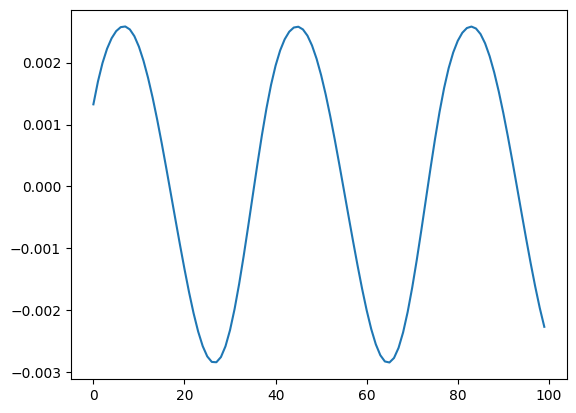

In [5]:
#Trying out different differentiators

#fd = FiniteDifference(is_uniform=True, order=1, d=1)
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 11})
#sfd = SmoothedFiniteDifference()
#diff = ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-3)

#xdot = fd._differentiate(x_rec, t_train [:, 0])
xdot = sfd._differentiate(x_rec , t_train[:, 0])
# xdotdot = sfd._differentiate(xdot, t_train[:, 0])
#xdot = diff._differentiate(x_rec,t_train)

#data_x_train = np.hstack((x_rec, xdot))
data_x_train = np.hstack((x_rec, xdot, t_train))

print(data_x_train.shape)
print(t_train.shape)
print(xdot.shape)
#print(xdotdot.shape)

plt.plot(x_rec [:100, 0])

Lets fit the model and build the necessary library to represent the dynamics of your system

1.(a): Polynomial+ Fourier Library

In [5]:
""" poly_order = 1
max_iter = 10000

#for STLSQ
threshold = 0.3  # optimized value = 0.3 if polyorder=1
regularization_on_weight = 0.09    # default is 0.05

#variable thresholding for SR3 optimizers
thresholds = 0.05* np.ones((5, 2))
thresholds[2:, :] = 0.1  #  Determines the strength of the regularization. When the regularization function R is the L0 norm, the regularization is equivalent to performing hard thresholding, and lambda is chosen to threshold at the value given by this parameter. This is equivalent to choosing lambda = threshold^2 / (2 * nu).
nu = 2 #Determines the level of relaxation. Decreasing nu encourages w and v to be close, whereas increasing nu allows the regularized coefficients v to be farther from w.
tol = 0.00001 #for determining convergence

#sr3 = ps.SR3(thresholder="weighted_l0", thresholds=thresholds, max_iter=max_iter, nu=nu, tol=tol)
stlsq =ps.STLSQ(alpha=regularization_on_weight, threshold=threshold, max_iter=max_iter)

lib_poly = ps.feature_library.PolynomialLibrary(degree = poly_order)
lib_fourier = ps.feature_library.FourierLibrary(n_frequencies = 1, include_sin=False, include_cos=True)

functions = [lambda x:x,
             lambda x,y : np.cos(x * y)
]
function_names = [lambda x : x,
                  lambda x,y : 'cos(' + x +', ' + y +')'
    
]
lib_custom = ps.CustomLibrary(library_functions = functions, function_names=function_names)

model_sine=ps.SINDy(
    optimizer=stlsq,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot"],
    discrete_time=False,
    feature_library=ps.feature_library.ConcatLibrary([lib_poly, lib_fourier])
    )

model_sine.fit(data_x_train, 1/sampling_rate)
model_sine.print()
model_sine.get_feature_names() """

(x)' = 1.000 xdot
(xdot)' = 44424739346.230 1 + -245280717.897 x + -28.814 xdot + -44424822098.863 cos(1 x) + -1626.067 cos(1 xdot)


['1', 'x', 'xdot', 'cos(1 x)', 'cos(1 xdot)']

1(b) Generalized Library

In [6]:
import numpy as np

poly_order = 3
max_iter = 1000

# for STLSQ
regularization_on_weight = 0.0
threshold = 0.1
# #variable thresholding for SR3 optimizers
# thresholds = 0.01 * np.ones((10, 3))
# thresholds[3 :4, :] = 1.25
# nu = 1
# tol= 0.01

#ensemble_optimizer = ps.EnsembleOptimizer(ps.STLSQ(threshold=threshold, alpha=regularization_on_weight, normalize_columns=False, max_iter=max_iter), bagging=True, replace=False, n_subset=1000, n_models=6, ensemble_aggregator=np.median)
stlsq = ps.STLSQ(threshold=threshold, alpha=regularization_on_weight, max_iter=max_iter)
#sr3 = ps.SR3(thresholder="weighted_l0", thresholds=thresholds, max_iter=max_iter, nu=nu, tol=tol)

#Initialize Libraries

#lib_poly = ps.feature_library.PolynomialLibrary(degree = poly_order, include_interaction=False, include_bias=False)

#lib_fourier = ps.feature_library.FourierLibrary(n_frequencies = 1, include_cos=False, include_sin=True)

funct = [lambda x : x,
         lambda x : x ** 3 ,
         #lambda x,y : (x* y)
        ]

names = [lambda x : '(' + x + ')',
         lambda x : '(' + x + '^' '3' ')',
         #lambda x, y : '(' + x + '*' + y + ')'
         ]
lib_xdot = ps.CustomLibrary(library_functions=funct, function_names=names)

lib_id = ps.IdentityLibrary()

# functions = [#lambda x :  np.cos(x * 750),
#             lambda x :  np.cos(x * 2517),
#             lambda x :  np.cos(x * 5034),
#             lambda x :  np.cos(x * 7551),
#             lambda x :  np.cos(x * 10070),
#             lambda x :  np.cos(x * 12590),
#             lambda x :  np.cos(x * 15100),
            #lambda x :  np.cos(x * 16000),
            #lambda x :  np.cos(x * 18048.3)
# ]
functions = [lambda x :  np.cos(x * 2517),
             lambda x :  np.cos(x * 5034),
             lambda x :  np.cos(x * 7551),
             lambda x :  np.cos(x * 10068),
             lambda x :  np.cos(x * 12585)
            ]
# functions = [lambda x :  np.cos(x * 7422.5),
#             lambda x :  np.cos(x * 14844.1),
#             lambda x :  np.cos(x * 22266.2),
#             lambda x :  np.cos(x * 29688.2),
#             lambda x :  np.cos(x * 37110.3),
#             # lambda x :  np.cos(x * 9648),
#             # lambda x :  np.cos(x * 10389),
#             # lambda x :  np.cos(x * 11880),
#             # lambda x :  np.cos(x * 13362),
#             # lambda x :  np.cos(x * 14095),
#             # lambda x :  np.cos(x * 14837),
#             ]
# function_names = [lambda x : 'cos(' + x + '*' '7422.2' ')',
#                   lambda x : 'cos(' + x + '*' '14844.1' ')',
#                   lambda x : 'cos(' + x + '*' '22266.2' ')',
#                   lambda x : 'cos(' + x + '*' '29688.2' ')',
#                   lambda x : 'cos(' + x + '*' '37110.3' ')',
#                 #   lambda x : 'cos(' '12590', '*', + x + ')',
#                 #   lambda x : 'cos(' '15100', '*', + x+ ')'
#                     ]
function_names = [lambda x : 'cos(' + x + '*' '2517' ')',
                  lambda x : 'cos(' + x + '*' '5034' ')',
                  lambda x : 'cos(' + x + '*' '7551' ')',
                  lambda x : 'cos(' + x + '*' '10068' ')',
                  lambda x : 'cos(' + x + '*' '12585' ')'
                 ]  

lib_custom = ps.CustomLibrary(library_functions=functions, function_names=function_names)
 
inputs_per_library = [[0, 0, 1],  [2, 2, 2]]

inputs_per_library = np.reshape(inputs_per_library, (2, 3))

# Tensor all the polynomial and Fourier library terms together
tensor_array = [[0, 1, 1]]

generalized_library = ps.GeneralizedLibrary([lib_xdot,  lib_custom], 
                                            #tensor_array=tensor_array,
                                            #exclude_libraries=[1],
                                            inputs_per_library=inputs_per_library)

model_sine=ps.SINDy(
    optimizer=stlsq,
    #optimizer=ensemble_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    # differentiation_method=diff,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library 
    )
model_sine.fit(data_x_train, 1/sampling_rate)
#model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=500, n_models=6, quiet=True, unbias=True, ensemble_aggregator=np.median)
model_sine.print(lhs=['dx/dt', 'd(xdot)/dt', 'dt/dt'])
#ensemble_coefs = model_sine.coef_list
model_sine.get_feature_names()

dx/dt = 1.000 (xdot)
d(xdot)/dt = -242828692.900 (x) + 1506.032 (xdot) + -1255135655034.686 (x^3) + -1.035 (xdot^3) + -376.930 cos(t*2517) + 390.107 cos(t*5034) + -59.419 cos(t*7551) + -30.603 cos(t*10068) + 106.688 cos(t*12585)
dt/dt = 278.747 (x) + -49905586.866 (x^3)


['(x)',
 '(xdot)',
 '(x^3)',
 '(xdot^3)',
 'cos(t*2517)',
 'cos(t*5034)',
 'cos(t*7551)',
 'cos(t*10068)',
 'cos(t*12585)']

# calculating equivalent frequency and amplitude

# Plotting force-deflection characteristics 

(960001, 1)
0.0026843346999876026


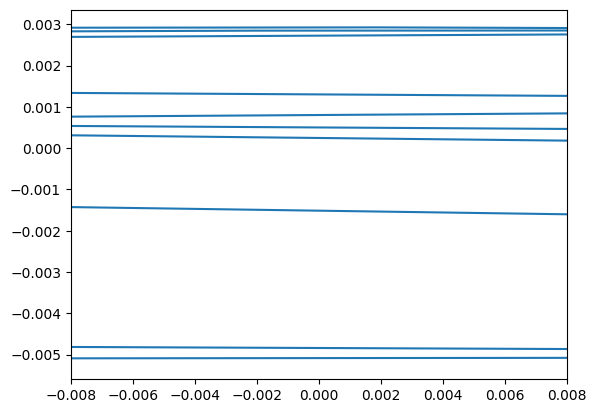

In [7]:
t = t_array[:, 0] * 7420
stable_signal = read_out_raw[40000:, 0]
F = 376.930 * np.cos(t*2517)/(7420**2 * np.max(stable_signal)) - 390.107 * np.cos(t*5034)/(7420**2 * np.max(stable_signal))
+ 59.419 * np.cos(t*7551)/(7420**2 * np.max(stable_signal)) + 30.603 * np.cos(t*10068)/(7420**2 * np.max(stable_signal)) - 106.688 * np.cos(t*12585)/(7420**2 * np.max(stable_signal))
F = F[:, np.newaxis]
print(F.shape)
y = stable_signal/np.max(stable_signal)
y = y[:, np.newaxis]
plt.figure()
plt.xlim(-0.008, 0.008)
plt.plot(y[40000:40200, 0], F[40000:40200, 0] )
print(np.max(stable_signal))

(920001, 1)
(920001, 1)
(920001, 1)


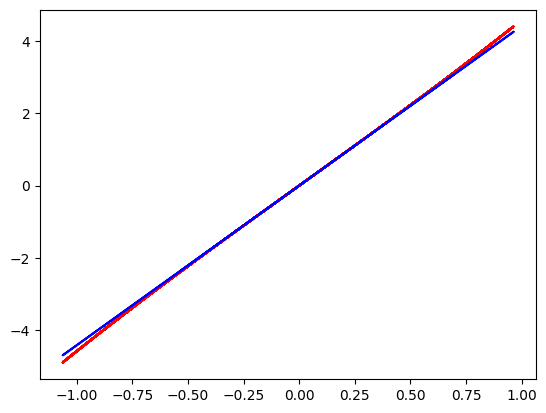

In [20]:
x_nd = stable_signal/np.max(stable_signal)
x_nd = x_nd[:, np.newaxis]

F_stiffness = (242828692.900 *(x_nd ))/(7420 ** 2) + ((1255135655034.686 *(x_nd **3)) * (np.max(stable_signal) ** 2))/(7420 ** 2)
#F_stiffness = F_stiffness[:, np.newaxis]

F_linear = (242828692.900 *(x_nd ))/(7420 ** 2)
#F_linear = F_linear[:, np.newaxis]

print(F_stiffness.shape)
print(F_linear.shape)
print(x_nd.shape)
stiffness = np.hstack((F_stiffness, F_linear, x_nd))

plt.plot(x_nd[:1000, 0],F_stiffness[:1000, 0], 'r')
plt.plot(x_nd[:1000, 0], F_linear[:1000, 0], 'b')
#plt.xlim(-0.003, 0.003)
np.savetxt('stiffness_voltage.txt', stiffness) 

(4000, 1)


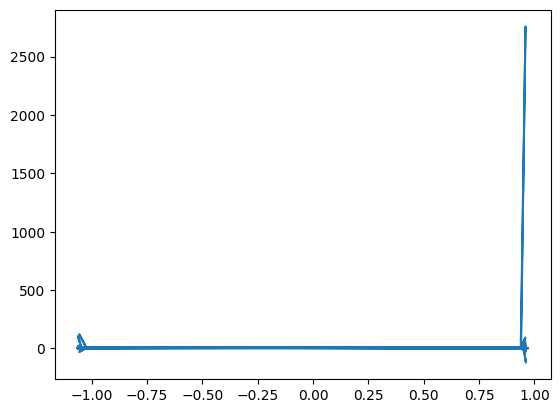

In [26]:
potential_energy = sfd._differentiate(F_stiffness[:4000, 0], x_nd[:4000, 0])
potential_energy = potential_energy[:, np.newaxis]
print(potential_energy.shape)
x_pot = x_nd[:4000, 0]
x_pot = x_pot[:, np.newaxis]
plt.plot(x_pot[:, 0], potential_energy[:, 0])
potential = np.hstack((potential_energy, x_pot))
np.savetxt('potential_voltage.txt', potential)

# Checking error for introducing time as a state variable

In [7]:
x = x_rec[2:3, 0]
t = t_train [2:3, 0]
xdot_1 = xdot[2:3, 0]
z = 278.747 * (x) -49905586.866 * (x**3)
print(1-z)

[0.83951478]


Post-processing for 'Ensembling' : Weighted average of the coefficients, with weights corresponding to the mean-squared error with the testing set

In [30]:
""" # function to compute the average of the coefficients, weighted by the MSE on the test data.

dt = 1/sampling_rate

def weighted_coefficient_average(coef_list, x_test, dt, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        mse[i] = model_sine.score(x_test, t=dt, metric=mean_squared_error)
    avg = np.average(coef_list, axis=0, weights=mse)
    coef_subtracted = np.zeros(np.shape(coef_list))
    for i in range(np.shape(coef_list)[0]):
        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg
    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))
    return avg, std

x_rec_test = read_out[43000 : 45000]
xdot_test = xdot_whole[43000 : 45000]
t_test = t_array[43000 : 45000]
t_test = np.array(t_test)
t_test= t_test[:,np.newaxis]
x_test = np.hstack((x_rec_test, xdot_test, t_test))

e_wavg, e_wstd = weighted_coefficient_average(
    ensemble_coefs, x_test, dt, ensemble_optimizer
)
# l_wavg, l_wstd = weighted_coefficient_average(
#     library_ensemble_coefs, x_test, dt, library_ensemble_optimizer
# ) 

# function to zero out any short-term unstable models 

def integration_metric(coef_list, optimizer):
    
    # Try 5 test trajectories
    
    batch_size = 2000
    number_batches = 5
    
    for k in range(number_batches):
        
        start_index = k * batch_size + 43000
        end_index = start_index +batch_size
        
        x_rec_test = read_out[start_index : end_index]
        xdot_test = xdot_whole[start_index : end_index]
        t_test = t_array[start_index : end_index]
        t_test = np.array(t_test)
        t_test= t_test[:,np.newaxis]
        
        data_x_test = np.hstack((x_rec_test, xdot_test, t_test))
        
        for i in range(np.shape(coef_list)[0]):
            optimizer.coef_ = coef_list[i, :, :]
            x_test_sim = model_sine.simulate(data_x_test[0], t_test [:, 0], integrator="odeint")
            if np.any(np.abs(x_test_sim) > 5000):
                # print('unstable model!')
                coef_list[i, :, :] = 0.0
    return coef_list



stable_ensemble_coefs = integration_metric(
    np.asarray(ensemble_coefs), ensemble_optimizer
)
# stable_library_ensemble_coefs = integration_metric(
#     np.asarray(library_ensemble_coefs), library_ensemble_optimizer
# ) """

' # function to compute the average of the coefficients, weighted by the MSE on the test data.\n\ndt = 1/sampling_rate\n\ndef weighted_coefficient_average(coef_list, x_test, dt, optimizer):\n    mse = np.zeros(np.shape(coef_list)[0])\n    for i in range(np.shape(coef_list)[0]):\n        optimizer.coef_ = np.asarray(coef_list)[i, :, :]\n        mse[i] = model_sine.score(x_test, t=dt, metric=mean_squared_error)\n    avg = np.average(coef_list, axis=0, weights=mse)\n    coef_subtracted = np.zeros(np.shape(coef_list))\n    for i in range(np.shape(coef_list)[0]):\n        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg\n    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))\n    return avg, std\n\nx_rec_test = read_out[43000 : 45000]\nxdot_test = xdot_whole[43000 : 45000]\nt_test = t_array[43000 : 45000]\nt_test = np.array(t_test)\nt_test= t_test[:,np.newaxis]\nx_test = np.hstack((x_rec_test, xdot_test, t_test))\n\ne_wavg, e_wstd = weighted_coefficient_aver

Plot bagging, bragging, and other post-processing results with error bars

In [31]:

""" coef_types = [np.mean(ensemble_coefs, axis=0), 
              np.median(ensemble_coefs, axis=0),
              np.mean(stable_ensemble_coefs, axis=0), 
             ]
coef_stds = [np.std(ensemble_coefs, axis=0), 
             np.std(ensemble_coefs, axis=0), 
             np.std(stable_ensemble_coefs, axis=0), 
            ]

# define some plotting needs

colors = ['b', 'r', 'k']
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
textstrs = ['bagging', 'bragging', 'weighted\nbagging', 
            'stability\nweighted\nbagging']
plt.figure(figsize=(16, 9))

# Loop over the different post-processed coefficients
for k, coefs in enumerate(coef_types):
    coef_std = coef_stds[k]
    plt.subplot(4, 2, k + 1)
    for i in range(coefs.shape[0]):
        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], 
                     fmt='o', color=colors[i], 
                     label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
    ax = plt.gca()
    ax.set_xticks(range(10))
    if k >= 6:
        xticknames = model.get_feature_names()
        for i in range(10):
            xticknames[i] = '$' + xticknames[i] + '$'
        ax.set_xticklabels(xticknames, verticalalignment='top', fontsize=28)
    else:
        ax.set_xticklabels([])
    plt.ylim(-20, 35)
    if k == 0:
        plt.legend(fontsize=18, framealpha=1.0, loc='upper right')
        ax.text(0.38, 1.15, 'ensemble', transform=ax.transAxes, 
                fontsize=20, bbox=props)
    if k == 1:
        ax.text(0.35, 1.15, 'library ensemble', transform=ax.transAxes, 
                fontsize=20, bbox=props)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)
    ax.set_yticks([-20, -10, 0, 10, 20, 30])
    if k % 2 == 0:
        textstr = textstrs[k // 2]
        ax.text(-0.35, 0.4, textstr, transform=ax.transAxes, 
                fontsize=20, bbox=props)
    else:
        ax.set_yticklabels([]) """

" coef_types = [np.mean(ensemble_coefs, axis=0), \n              np.median(ensemble_coefs, axis=0),\n              np.mean(stable_ensemble_coefs, axis=0), \n             ]\ncoef_stds = [np.std(ensemble_coefs, axis=0), \n             np.std(ensemble_coefs, axis=0), \n             np.std(stable_ensemble_coefs, axis=0), \n            ]\n\n# define some plotting needs\n\ncolors = ['b', 'r', 'k']\nprops = dict(boxstyle='round', facecolor='wheat', alpha=1.0)\ntextstrs = ['bagging', 'bragging', 'weighted\nbagging', \n            'stability\nweighted\nbagging']\nplt.figure(figsize=(16, 9))\n\n# Loop over the different post-processed coefficients\nfor k, coefs in enumerate(coef_types):\n    coef_std = coef_stds[k]\n    plt.subplot(4, 2, k + 1)\n    for i in range(coefs.shape[0]):\n        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], \n                     fmt='o', color=colors[i], \n                     label='$\\dot ' + feature_names[i] + '_{}$' + ' coefficients')\n   

In [32]:
print(data_x_train[0])

[-1.40708691e-03  4.38104836e+01  4.16666667e-01]


Defining Test_set to evaluate model stability

In [17]:
# validation 218001+2000. test set varies
x_test = read_out_raw[300001 : 302001]
t_test = t_array[300001 : 302001]
t_test = np.array(t_test)
t_test = t_test[:,np.newaxis]

xdot_test = sfd._differentiate(x_test, t_test[:, 0])
data_x_train_test = np.hstack((x_test, xdot_test, t_test))
print(data_x_train_test.shape)

(2000, 3)


# Plotting learning curve

In [16]:
""" import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Step 3: Initialize arrays to store performance metric
train_metric = []
val_metric = []

# Step 4: Loop over the desired number of iterations
num_iterations = 1000
for i in range(1, num_iterations+1):
    # Train the model on the training set
    model_sine.fit(data_x_train, 1/sampling_rate)
    # Evaluate performance on the training set
    y_train_pred = model_sine.simulate(np.array(data_x_train[0]), t_train[:,0]) 
    train_accuracy = r2_score(x_rec[:, 0], y_train_pred[:,0])
    train_accuracy = "{:.4f}".format(train_accuracy)
    
    # Evaluate performance on the validation set
    y_val_pred = model_sine.simulate(np.array(data_x_train_test[0]), t_test[:,0]) 
    val_accuracy = r2_score(data_x_train_test[:, 0], y_val_pred[:,0])
    val_accuracy = "{:.4f}".format(val_accuracy)
    
    # Store the performance metric
    train_metric.append(train_accuracy)
    val_metric.append(val_accuracy)

# Step 5: Plot the learning curve
plt.plot(range(1, num_iterations+1), train_metric, label='Training Set')
plt.plot(range(1, num_iterations+1), val_metric, label='Validation Set')
plt.xlabel('Number of Iterations')
plt.ylabel('Performance Metric')
plt.title('Learning Curve')
plt.legend()
plt.show() """

' import numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import r2_score\n\n\n# Step 3: Initialize arrays to store performance metric\ntrain_metric = []\nval_metric = []\n\n# Step 4: Loop over the desired number of iterations\nnum_iterations = 1000\nfor i in range(1, num_iterations+1):\n    # Train the model on the training set\n    model_sine.fit(data_x_train, 1/sampling_rate)\n    # Evaluate performance on the training set\n    y_train_pred = model_sine.simulate(np.array(data_x_train[0]), t_train[:,0]) \n    train_accuracy = r2_score(x_rec[:, 0], y_train_pred[:,0])\n    train_accuracy = "{:.4f}".format(train_accuracy)\n    \n    # Evaluate performance on the validation set\n    y_val_pred = model_sine.simulate(np.array(data_x_train_test[0]), t_test[:,0]) \n    val_accuracy = r2_score(data_x_train_test[:, 0], y_val_pred[:,0])\n    val_accuracy = "{:.4f}".format(val_accuracy)\n    \n    # Store the performance metric\n    train_metric.append(train_accuracy)\n    val_

Now , Simulate the discovered model forward in time providing the initial condition.

In [18]:
# # Training evaluation 
# sim = model_sine.simulate(np.array(data_x_train[0]), t_train[:, 0], integrator="odeint") 

#Model stability evaluation
sim = model_sine.simulate(np.array(data_x_train_test[0]), t_test[:,0], integrator="odeint")

sim.shape

(2000, 3)

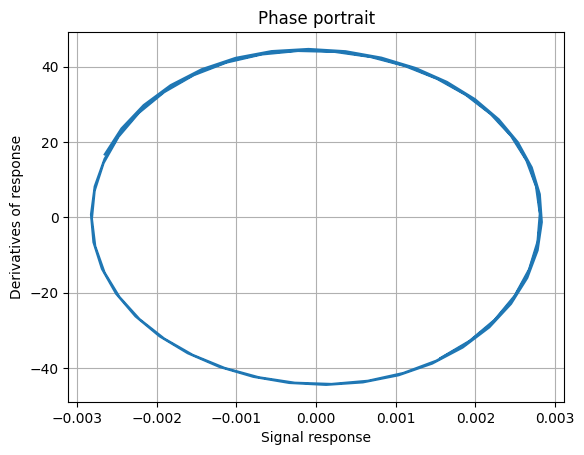

In [27]:
# Create the plot

plt.plot(sim[:100, 0], sim[:100, 1])

# Set the log scale on the y-axis
#plt.yscale('log')

# Set labels and title
plt.xlabel('Signal response')
plt.ylabel('Derivatives of response')
plt.title('Phase portrait')

# Display the plot
plt.grid(True)
plt.show()

In [28]:
np.savetxt('simulated_final_volt.txt', sim)

Evaluating error and R2_score

In [19]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# R2_score_train = r2_score(data_x_train[:, 0], sim[:, 0])
# R2_score_train = "{:.3f}".format(R2_score_train)
# Pearson_correlation_train = pearsonr(data_x_train[:, 0], sim[:, 0])
# Pearson_correlation_train = "{:.3f}".format(Pearson_correlation_train[0])

# print(f"The observed R2_score for the voltage training_set is:",R2_score_train)
# print(f"The Pearson_correlation for the voltage training_set is :", Pearson_correlation_train)

R2_score_test = r2_score(data_x_train_test[:, 1], sim[:, 1])
R2_score_test = "{:.3f}".format(R2_score_test)
Pearson_correlation_test = pearsonr(data_x_train_test[:, 1], sim[:, 1])
Pearson_correlation_test = "{:.3f}".format(Pearson_correlation_test[0])

print(f"The observed R2_score for the voltage test_set is:",R2_score_test)
print(f"The Pearson_correlation for the voltage test_set is :", Pearson_correlation_test )

The observed R2_score for the voltage test_set is: 0.971
The Pearson_correlation for the voltage test_set is : 0.986


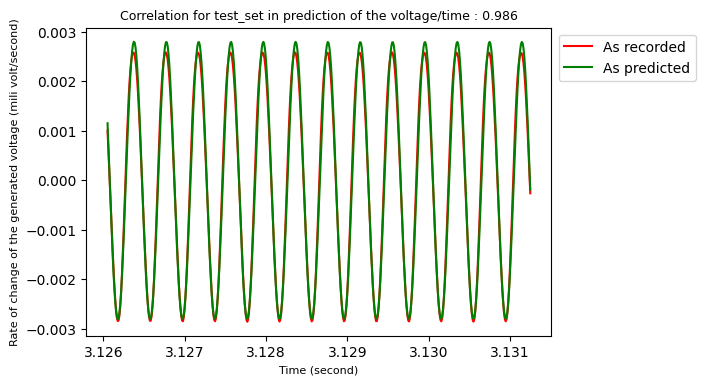

In [22]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.set_ylabel('Rate of change of the generated voltage (mili volt/second)', fontsize=8)
#ax.set_ylabel('Generated voltage (mili volt)', fontsize=8)
ax.set_xlabel('Time (second)', fontsize=8)

# # ax.set_title(f'R2_score for training is : {R2_score_train} ')
# ax.set_title(f'Correlation for training_set in prediction of the voltage : {Pearson_correlation_train}',  fontsize=9 )

# plt.plot( t_train[0:500, 0], data_x_train[0:500, 0], 'r', label="As recorded")
# plt.plot( t_train[0:500, 0], sim[0:500, 0], 'g',  label="As predicted")


#ax.set_title(f'Correlation for validation_set in prediction of the voltage/time : {R2_score_test}', fontsize=9)
ax.set_title(f'Correlation for test_set in prediction of the voltage/time : {Pearson_correlation_test}', fontsize=9)

plt.plot( t_test[100:600, 0], data_x_train_test[100:600, 0], 'r', label="As recorded")
plt.plot( t_test[100:600, 0], sim[100:600, 0], 'g',  label="As predicted")

ax.legend(loc='upper left',  bbox_to_anchor=(1.0005, 1))

In [50]:
# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = 1/sampling_rate
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test[:,0], integrator="odeint")
        # if np.any(x_test_sim > 1e4):
        #     x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test[:,0] - x_test_sim[:, 0]) ** 2)
    
    plt.figure()
    plt.semilogy(threshold_scan, mse, "ro")
    plt.semilogy(threshold_scan, mse, "g")
    plt.title(" Effect of threshold value on xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"threshold values", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "yo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.title(" Effect of threshold value on simulated xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"threshold values", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

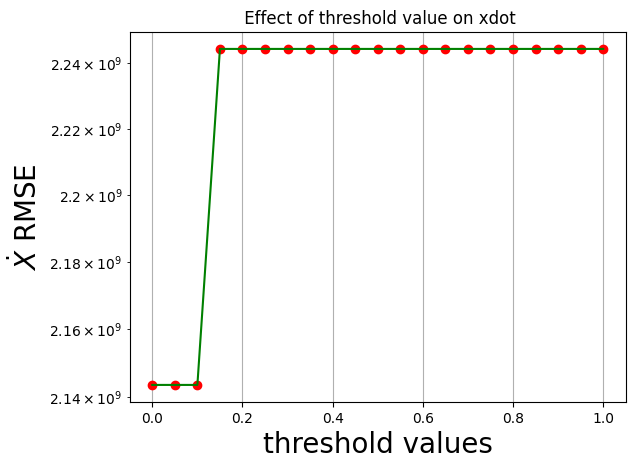

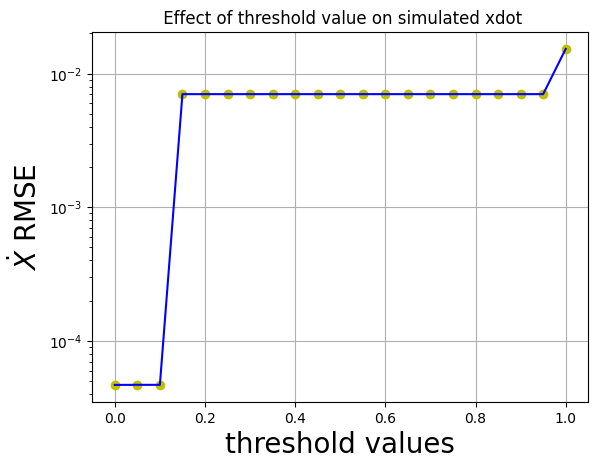

In [51]:
threshold_scan = np.arange(0, 1.05, 0.05)
coefs = []
rmse = mean_squared_error(data_x_train, np.zeros(data_x_train.shape), squared=False)

#x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model_sine = ps.SINDy(
    optimizer=sparse_regression_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    )
    model_sine.fit(data_x_train, 1/sampling_rate, quiet=True)
    #model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=1000, n_models=3, quiet=True, unbias=False, ensemble_aggregator=np.median)
    coefs.append(model_sine.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model_sine,
            threshold_scan, data_x_train_test, t_test)

# 2. Optimizing regularization parameter 'alpha'

In [52]:
# Make coefficient plot for regularization scan
def plot_pareto(coefs, opt, model, regularization_scan, x_test, t_test):
    dt = 1/sampling_rate
    mse = np.zeros(len(regularization_scan))
    mse_sim = np.zeros(len(regularization_scan))
    for i in range(len(regularization_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test[:,0], integrator="odeint")
        # if np.any(x_test_sim > 1e4):
        #     x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test[:,0] - x_test_sim[:, 0]) ** 2)
    
    plt.figure()
    plt.semilogy(regularization_scan, mse, "ro")
    plt.semilogy(regularization_scan, mse, "g")
    plt.title(" Effect of alpha on xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\alpha$", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    
    plt.figure()
    plt.semilogy(regularization_scan, mse_sim, "yo")
    plt.semilogy(regularization_scan, mse_sim, "b")
    plt.title(" Effect of alpha on simulated xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\alpha$", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

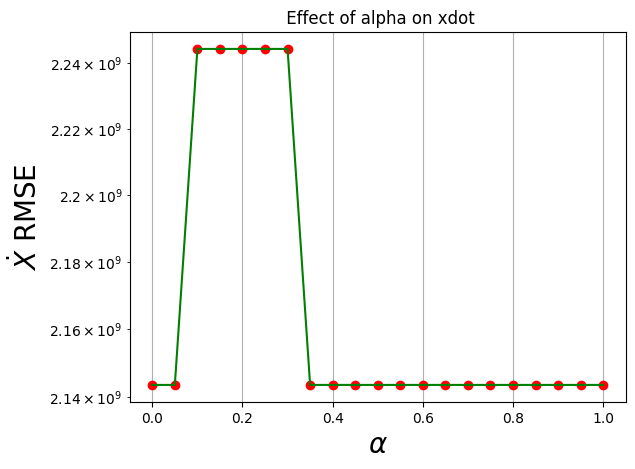

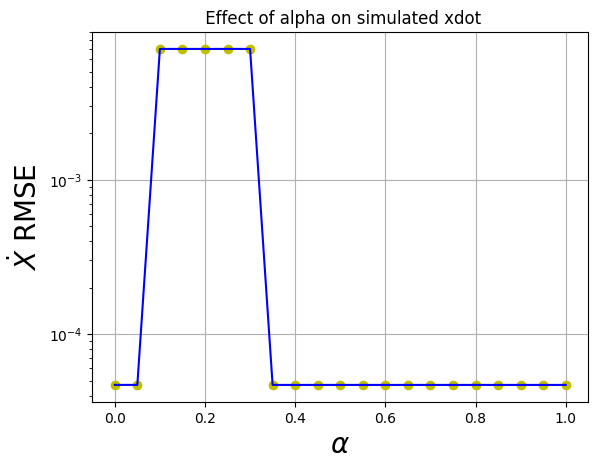

In [53]:
regularization_scan = np.arange(0, 1.05, 0.05)
coefs = []
rmse = mean_squared_error(data_x_train, np.zeros(data_x_train.shape), squared=False)

#x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

for i, regularization in enumerate(regularization_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=0.1, alpha=regularization)
    model_sine = ps.SINDy(
    optimizer=sparse_regression_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    )
    #model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=1000, n_models=3, quiet=True, unbias=False, ensemble_aggregator=np.median)
    model_sine.fit(data_x_train, 1/sampling_rate, quiet=True)
    coefs.append(model_sine.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model_sine,
            regularization_scan, data_x_train_test, t_test)

# 2. Optimizing 'window_size' of utilized diffrentiation method 'Smoothed Finite Difference'

In [54]:
# Make coefficient plot for scanning optimized window_size
def plot_pareto(coefs, opt, model, window_size, x_test, t_test):
    dt = 1/sampling_rate
    mse = np.zeros(len(window_size))
    mse_sim = np.zeros(len(window_size))
    for i in range(len(window_size)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test[:,0], integrator="odeint")
        # if np.any(x_test_sim > 1e4):
        #     x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test[:,0] - x_test_sim[:, 0]) ** 2)
    
    # plt.figure()
    # plt.semilogy(window_size, mse, "ro")
    # plt.semilogy(window_size, mse, "g")
    # plt.title(" Effect of window_size on xdot")
    # plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    # plt.xlabel(r"window_size", fontsize=20)
    # plt.xticks(fontsize=10)
    # plt.yticks(fontsize=10)
    # plt.grid(True)
    
    plt.figure()
    plt.semilogy(window_size, mse_sim, "yo")
    plt.semilogy(window_size, mse_sim, "b")
    plt.title(" Effect of window_size ")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"window_size", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

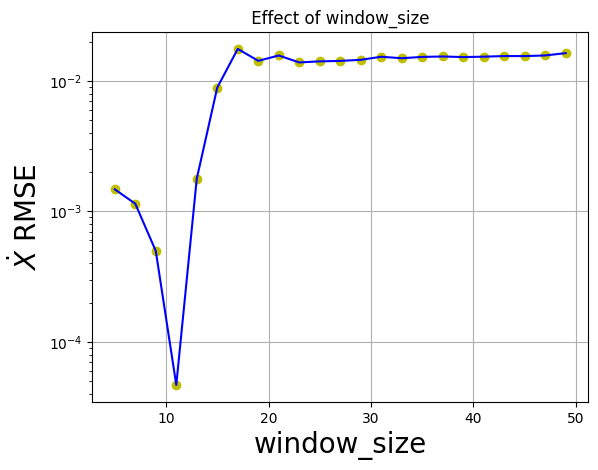

In [55]:
window_size = np.arange(5, 51, 2)
coefs = []
rmse = mean_squared_error(data_x_train, np.zeros(data_x_train.shape), squared=False)

#x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

for i, window in enumerate(window_size):
    sparse_regression_optimizer = ps.STLSQ(threshold=0.1, alpha=0.0)
    model_sine = ps.SINDy(
    optimizer=sparse_regression_optimizer,
    #optimizer=sr3,
    differentiation_method= SmoothedFiniteDifference(smoother_kws={'window_length': window}),
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    )
    #model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=1000, n_models=3, quiet=True, unbias=False, ensemble_aggregator=np.median)
    model_sine.fit(data_x_train, 1/sampling_rate, quiet=True)
    coefs.append(model_sine.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model_sine,
            window_size, data_x_train_test, t_test)

In [6]:
# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, iteration_scan, x_test, t_test):
    dt = 1/sampling_rate
    mse = np.zeros(len(iteration_scan))
    mse_sim = np.zeros(len(iteration_scan))
    for i in range(len(iteration_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test[:,0], integrator="odeint")
        # if np.any(x_test_sim > 1e4):
        #     x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test[:,0] - x_test_sim[:, 0]) ** 2)
    
    plt.figure()
    plt.semilogy(iteration_scan, mse, "ro")
    plt.semilogy(iteration_scan, mse, "g")
    plt.title(" Effect of No. of iteration on xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"No of iteration", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    
    plt.figure()
    plt.semilogy(iteration_scan, mse_sim, "yo")
    plt.semilogy(iteration_scan, mse_sim, "b")
    plt.title(" Effect of No. of iterationon simulated xdot")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"No of iteration", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

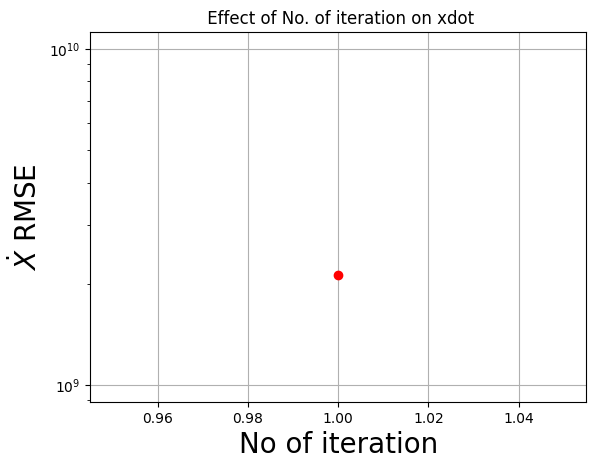

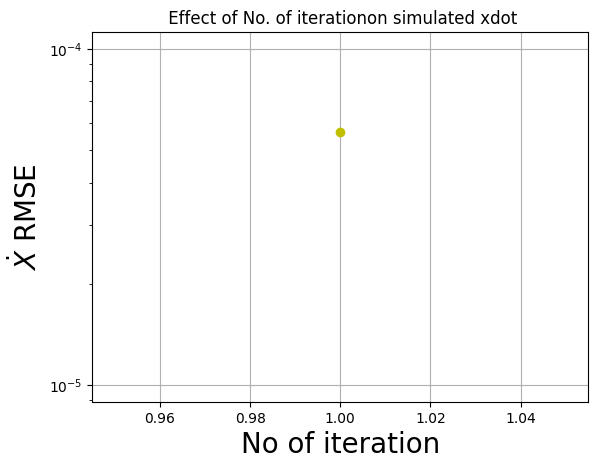

In [9]:
iteration_scan = np.arange(1, 101, 100, dtype=int)
coefs = []
rmse = mean_squared_error(data_x_train, np.zeros(data_x_train.shape), squared=False)

#x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

for i, iteration in enumerate(iteration_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=0.1, alpha=0.0, max_iter=iteration)
    model_sine = ps.SINDy(
    optimizer=sparse_regression_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library
    )
    model_sine.fit(data_x_train, 1/sampling_rate, quiet=True)
    #model_sine.fit(data_x_train, 1/sampling_rate, ensemble=True, replace=False, n_subset=1000, n_models=3, quiet=True, unbias=False, ensemble_aggregator=np.median)
    coefs.append(model_sine.coefficients())

plot_pareto(coefs, sparse_regression_optimizer, model_sine,
            iteration_scan, data_x_train_test, t_test)

In [8]:
t_array_new = np.array(t_array)
t_array_new = t_array_new[:, np.newaxis]
print(t_array_new.shape)


(960001, 1)


In [114]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

window_size = 4000
start_indices = np.arange(40001, 200001, window_size)  # Start indices for each portion
errors = []
errors_p = []
for start_index in start_indices:
    end_index = start_index + window_size
    portion_sig = read_out_raw[start_index:end_index]
    portion_time = t_array_new[start_index:end_index]
    portion_xdot = sfd._differentiate(portion_sig, portion_time [:, 0])
    data_x_train_new = np.hstack((portion_sig, portion_xdot, portion_time))
    model_sine=ps.SINDy(
    optimizer=stlsq,
    #optimizer=ensemble_optimizer,
    #optimizer=sr3,
    differentiation_method= sfd,
    # differentiation_method=diff,
    feature_names=["x", "xdot", "t"],
    discrete_time=False,
    feature_library=generalized_library 
    )
    model_sine.fit(data_x_train_new, 1/sampling_rate)
    
    sim_new = model_sine.simulate(np.array(data_x_train_new[0]), portion_time[:, 0], integrator="odeint") 
    # Calculate and store the error metrics of each portion

    error = r2_score(data_x_train_new[:, 0], sim_new[:, 0])
    error_p = pearsonr(data_x_train_new[:, 0], sim_new[:, 0])
    errors.append(error)
    errors_p.append(error_p)
    
    print(f"Start index: {start_index}, Error: {error, error_p}")

Start index: 40001, Error: (0.9618145119783895, PearsonRResult(statistic=0.9815532073906853, pvalue=0.0))
Start index: 44001, Error: (0.9117078063643705, PearsonRResult(statistic=0.9571481822377313, pvalue=0.0))
Start index: 48001, Error: (0.9111678504339865, PearsonRResult(statistic=0.956725173325402, pvalue=0.0))
Start index: 52001, Error: (0.9251934816201905, PearsonRResult(statistic=0.9636339138056386, pvalue=0.0))
Start index: 56001, Error: (0.9033714675983693, PearsonRResult(statistic=0.9528587938286184, pvalue=0.0))
Start index: 60001, Error: (0.9841566111973225, PearsonRResult(statistic=0.9924192249402111, pvalue=0.0))
Start index: 64001, Error: (0.96859503022271, PearsonRResult(statistic=0.9849349628934003, pvalue=0.0))
Start index: 68001, Error: (0.9828011624853211, PearsonRResult(statistic=0.9919227643661055, pvalue=0.0))
Start index: 72001, Error: (0.9623113286315513, PearsonRResult(statistic=0.9817938053020262, pvalue=0.0))
Start index: 76001, Error: (0.9263003168886312, P

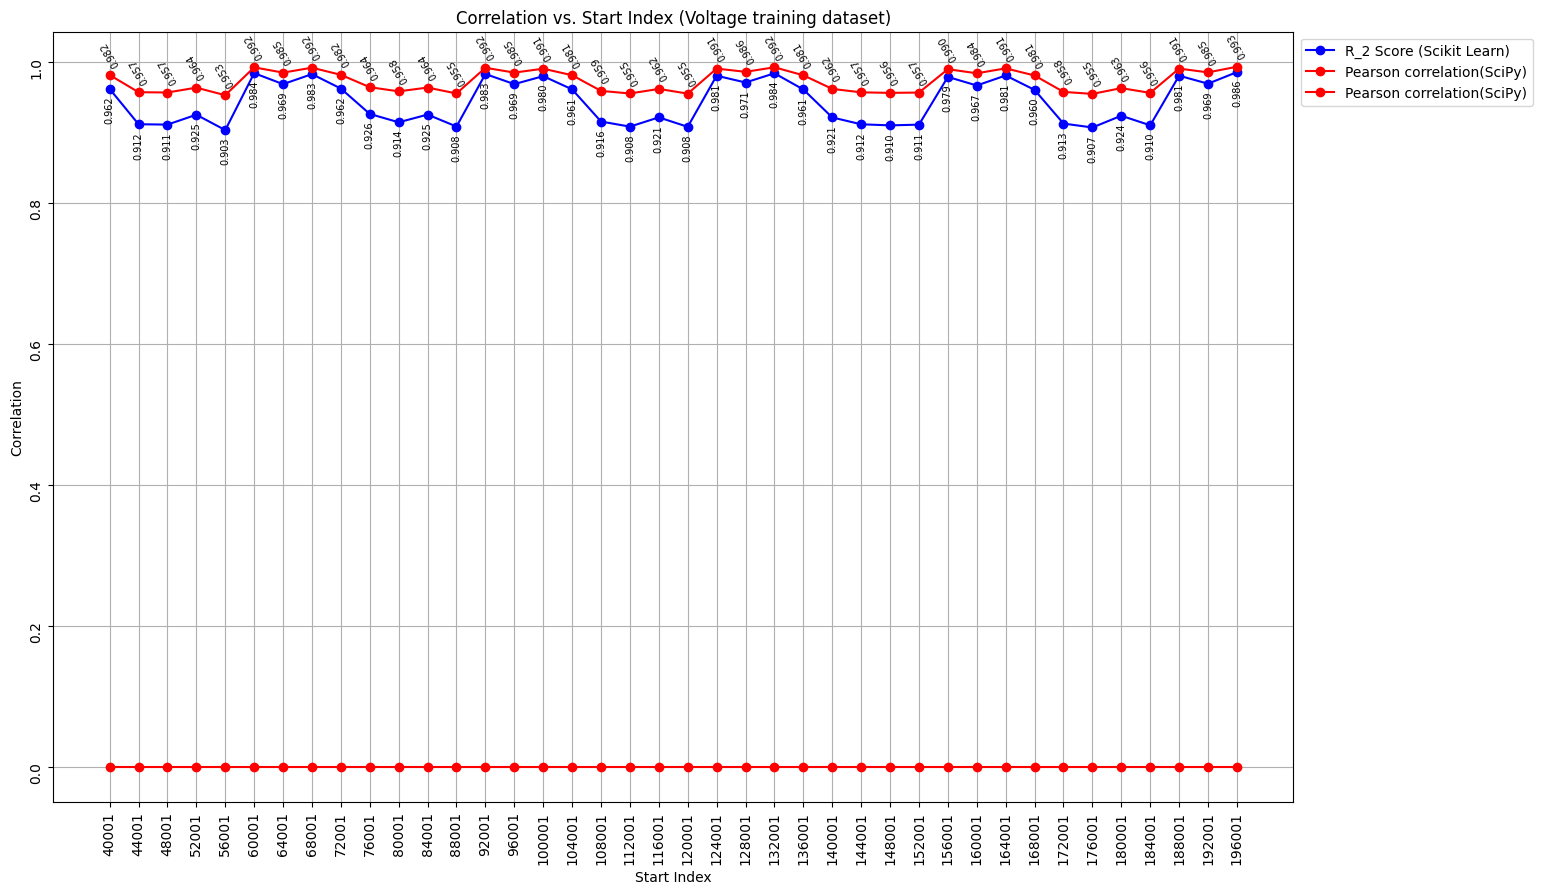

In [116]:
#from matplotlib.offsetbox import offset_copy
# Plotting the errors
plt.figure(figsize=(16, 10))
plt.xlabel('Start Index')
#plt.ylim(0.8, 1)
plt.ylabel('Correlation')
plt.title('Correlation vs. Start Index (Voltage training dataset)', loc='center')
plt.xticks(start_indices, fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=90)

# Plot the configurations and scores
plt.plot(start_indices, errors, marker='o', linestyle='-', color='b', label="R_2 Score (Scikit Learn)")
plt.plot(start_indices, errors_p, marker='o', linestyle='-', color='r', label="Pearson correlation(SciPy)")
plt.grid(True)

plt.legend(loc='upper left',  bbox_to_anchor=(1.0005, 1))

for x, score in zip(start_indices, errors):
    score_value = score
    text = "{:.3f}".format(score_value)
    text_y = score_value - 0.01  # Adjust the y-coordinate for positioning
    plt.text(x, text_y, text, ha='center', va='top', fontsize=7, rotation=90)


for x, corr in zip(start_indices, errors_p):
    corr_value = corr[0]  # Extract the first value (correlation)
    text = "{:.3f}".format(corr_value)
    text_y = corr_value + 0.01  # Adjust the y-coordinate for positioning
    plt.text(x, text_y, text, ha='center', va='bottom', fontsize=7, rotation=120)
plt.show()

In [111]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

window_size =2000
start_indices = np.arange(200001, 300001, window_size)  # Start indices for each portion
errors = []
errors_p = []
for start_index in start_indices:
    end_index = start_index + window_size
    portion_sig = read_out_raw[start_index:end_index]
    portion_time = t_array_new[start_index:end_index]
    portion_xdot = sfd._differentiate(portion_sig, portion_time [:, 0])
    data_x_train_new = np.hstack((portion_sig, portion_xdot, portion_time))

    
    sim_new = model_sine.simulate(np.array(data_x_train_new[0]), portion_time[:, 0], integrator="odeint") 
    # Calculate and store the error metrics of each portion

    error = r2_score(data_x_train_new[:, 0], sim_new[:, 0])
    error_p = pearsonr(data_x_train_new[:, 0], sim_new[:, 0])
    errors.append(error)
    errors_p.append(error_p)
    
    print(f"Start index: {start_index}, Error: {error, error_p}")

Start index: 200001, Error: (0.9914702038762223, PearsonRResult(statistic=0.9963035661598627, pvalue=0.0))
Start index: 202001, Error: (0.9811470148901313, PearsonRResult(statistic=0.9910182676657892, pvalue=0.0))
Start index: 204001, Error: (0.9859822801629371, PearsonRResult(statistic=0.9934906691036305, pvalue=0.0))
Start index: 206001, Error: (0.9871209558504774, PearsonRResult(statistic=0.9939525050458021, pvalue=0.0))
Start index: 208001, Error: (0.935606451443001, PearsonRResult(statistic=0.9690421013460006, pvalue=0.0))
Start index: 210001, Error: (0.9884431146829644, PearsonRResult(statistic=0.9945808561853464, pvalue=0.0))
Start index: 212001, Error: (0.9744552869801515, PearsonRResult(statistic=0.9878054802040372, pvalue=0.0))
Start index: 214001, Error: (0.9929640930430449, PearsonRResult(statistic=0.9970434515140453, pvalue=0.0))
Start index: 216001, Error: (0.9725258250631382, PearsonRResult(statistic=0.9867770162029691, pvalue=0.0))
Start index: 218001, Error: (0.9936794

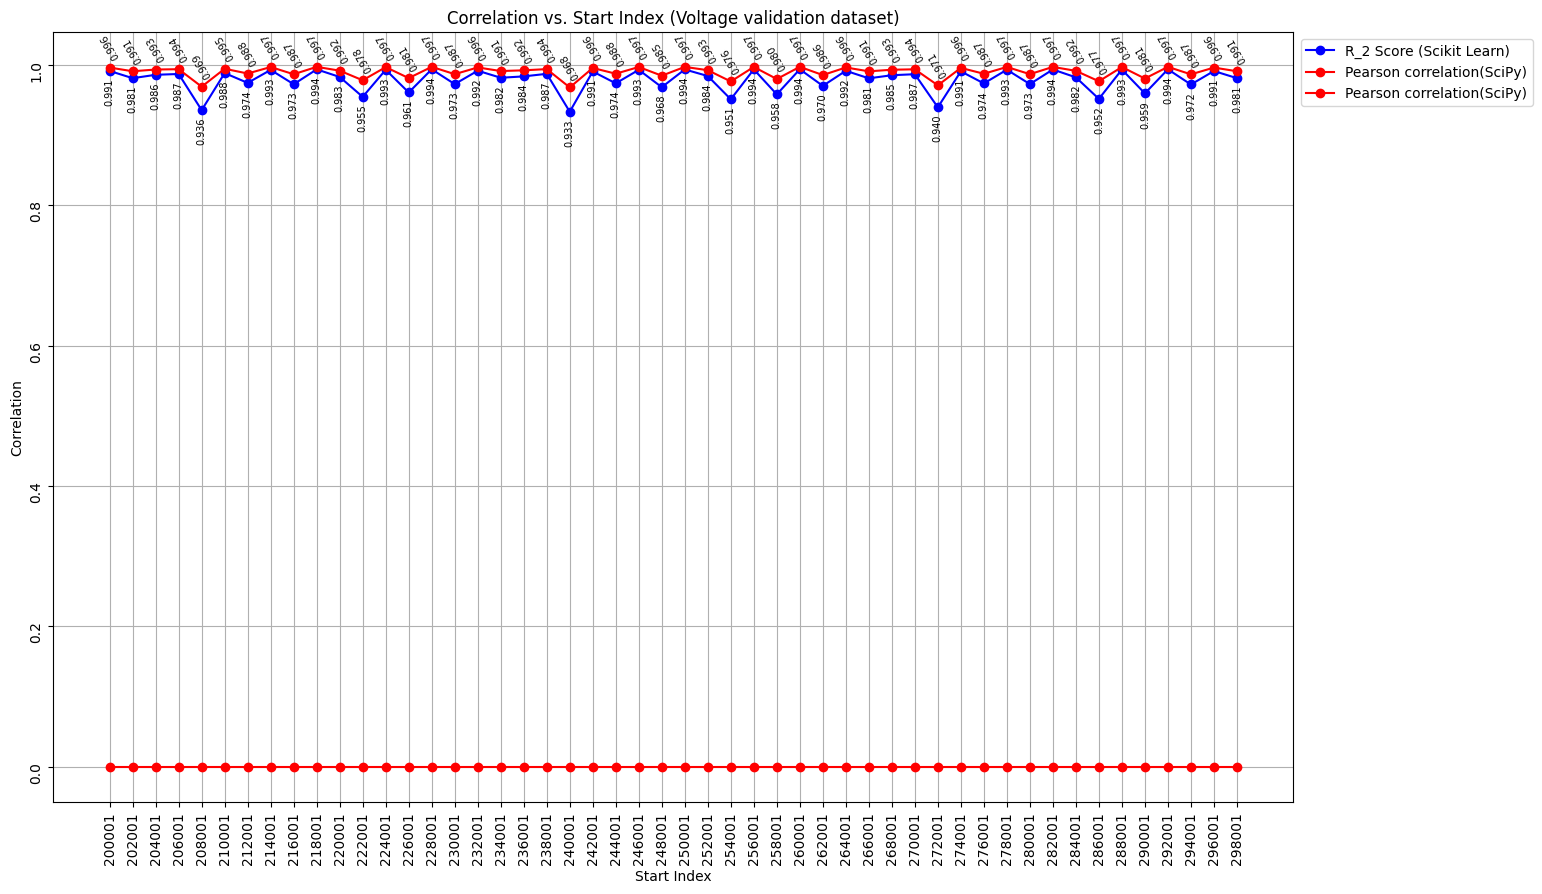

In [112]:
#from matplotlib.offsetbox import offset_copy
# Plotting the errors
plt.figure(figsize=(16, 10))
plt.xlabel('Start Index')
#plt.ylim(0.8, 1)
plt.ylabel('Correlation')
plt.title('Correlation vs. Start Index (Voltage validation dataset)', loc='center')
plt.xticks(start_indices, fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=90)

# Plot the configurations and scores
plt.plot(start_indices, errors, marker='o', linestyle='-', color='b', label="R_2 Score (Scikit Learn)")
plt.plot(start_indices, errors_p, marker='o', linestyle='-', color='r', label="Pearson correlation(SciPy)")
plt.grid(True)

plt.legend(loc='upper left',  bbox_to_anchor=(1.0005, 1))

for x, score in zip(start_indices, errors):
    score_value = score
    text = "{:.3f}".format(score_value)
    text_y = score_value - 0.01  # Adjust the y-coordinate for positioning
    plt.text(x, text_y, text, ha='center', va='top', fontsize=7, rotation=90)


for x, corr in zip(start_indices, errors_p):
    corr_value = corr[0]  # Extract the first value (correlation)
    text = "{:.3f}".format(corr_value)
    text_y = corr_value + 0.01  # Adjust the y-coordinate for positioning
    plt.text(x, text_y, text, ha='center', va='bottom', fontsize=7, rotation=120)
plt.show()